# Matt Lenert's Homework 1

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

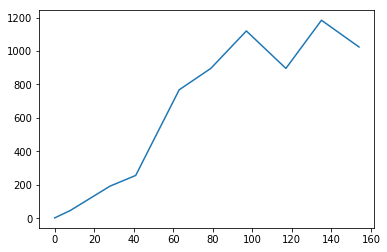

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using the Newton–Raphson approach to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

In [56]:
#N_R

# get logliklihood given k,r, and sigma. Spit out -log liklihood

# Then feed to optimize.minimize in sci-py

In [53]:
import sympy as sp
sp.init_printing()
n_0, k, r, t, y = sp.symbols("n_0 k r t y")
logEQ=((k * n_0) / (n_0 + (k-n_0) * sp.exp(-1 * r * t)))
sseEQ=((logEQ - y)**2)
H_inv=sp.hessian(sseEQ,(r, k)).T.inv()
F=sp.Matrix(2,1,[sp.diff(sseEQ,r),sp.diff(sseEQ,k)])
N_R=-1*H_inv*F

def getDelta(equation,init, cap, rate, times, y_n):
    original=sp.Matrix(2,1,[rate,cap])
    temp = sp.Add(*[equation.subs([(n_0,init),(k,cap),(r,rate),(t,times[i]),(y,y_n[i])]) for i in range(len(times))])
    print(temp)
    return(sp.Add(original,temp))

def sym_SSE(equation,init, cap, rate, times, y_n):
    return(sp.Add(*[equation.subs([(n_0,init),(k,cap),(r,rate),(t,times[i]),(y,y_n[i])]) for i in range(len(times))]))

def fitLogGrowth(endogenous,timePoints,rateInit,capacityInit, tol=1e-9, max_iter=100):
    SSEdiff=1
    i = 0
    SSEprev=0
    rate=rateInit
    capacity=capacityInit
    initial_number=endogenous[0]

    
    while (SSEdiff > tol) and (i < max_iter):

        SSE=sym_SSE(sseEQ,initial_number,capacity,rate,timePoints,endogenous)
        changes=getDelta(N_R,initial_number,capacity,rate,timePoints,endogenous)
        rate = changes[0]
        capacity = changes[1]
        SSEprev=SSE
        i+=1
        print(rate)
        print(capacity)
        print("-------")
    if i>=max_iter:
        print("Failed to Converge")
    
    return({"rate":rate,"capacity":capacity, "SSE":SSE})

In [55]:
#fitLogGrowth(beetles[1:],days[1:],days[-1]/beetles[-1],max(beetles))

In [125]:
# Part 1: Fit Logistic Growth Model
from scipy import optimize
import numpy as np

# Logistic growth equation
def solveLogisticGrowth(initial_number, rate, capacity, time):
    return ((capacity*initial_number)/(initial_number+(capacity-initial_number)*np.exp(-1*rate*time)))

# Partial derivative of logistic growth equation with respect to rate
# Used chain rule
def d_rate(initial_number, rate, capacity, time):
    return((capacity*initial_number*time*(capacity-initial_number)*np.exp(-1*rate*time))/(initial_number+(capacity-initial_number)*np.exp(-1*rate*time))**2)

# Partial derivative of logistic growth equation with respect to capacity
# Used quotient rule
def d_capacity(initial_number, rate, capacity, time):
    return(((initial_number**2)*np.exp(time*rate)*(np.exp(time*rate)-1))/(capacity+initial_number*(np.exp(time*rate)-1))**2)

# Generate predictions
def predict(func,initial_number, rate, capacity, timePoints):
    return(np.array([func(initial_number,rate,capacity,time) for time in timePoints]))
    
# The function to be optimized 
# Used *args to use numpy line search, but was unable to get numpy to give a solution
def solve_SSE(x,*args):
    endogenous=args[0]
    yHat=predict(solveLogisticGrowth,args[1],x[0],x[1],args[2])
    return(np.sum(np.square(yHat-np.array(endogenous))))

# Solve partial derivatives of SSE
def solve_dSSE(x,*args):
    endogenous=args[0]
    yHat=predict(solveLogisticGrowth,args[1],x[0],x[1],args[2])
    
    # Calculate predictions for partial derivative with respect to rate
    ratePartial=predict(d_rate,args[1],x[0],x[1],args[2])
    
    # Calculate predictions for partial derivative with respect to capacity
    capacityPartial=predict(d_capacity,args[1],x[0],x[1],args[2])
    
    # Apply chain rule to SSE = Sum of (2*(g(x_i, y_i, r, K))*dg(x_i, y_i, r, K)/dr ) 
    # and Sum of (2*(g(x_i, y_i, r, K))*dg(x_i, y_i, r, K)/dK )
    # Where g(x_i, y_i, r, K) = y_hat_i - y_i 
    return(np.array([np.sum(2*(yHat-np.array(endogenous))*ratePartial),np.sum(2*(yHat-np.array(endogenous))*capacityPartial)]))

def fitLogisticGrowth(endogenous,timePoints,rateInit,capacityInit, tol=1e-4, max_iter=10000):
    SSEdiff=1
    i = 0
    SSEprev=0
    rate=rateInit
    capacity=capacityInit
    initial_number=endogenous[0]
    
    while (SSEdiff > tol) and (i < max_iter):

        SSE=solve_SSE([rate,capacity],endogenous,initial_number,timePoints)
        dRate, dCapacity=solve_dSSE([rate,capacity],endogenous,initial_number,timePoints)
        
        # Heuristic: Shrink step size as SSE shirnks 
        r_step=SSE/1000000000000000
        c_step= SSE/100000000
        
        SSEdiff=np.abs(SSE-SSEprev)
        rate += -dRate*r_step
        capacity += -dCapacity*c_step
        SSEprev=SSE
        i+=1
        
    if i>=max_iter:
        print("Failed to Converge")
    
    return({"rate":rate,"capacity":capacity, "SSE":SSE})

In [152]:
results=fitLogisticGrowth(beetles,days,days[-1]/beetles[-1],max(beetles))
results

{'rate': 0.11795435223430668,
 'capacity': 1033.5564420634043,
 'SSE': 83240.49407026863}

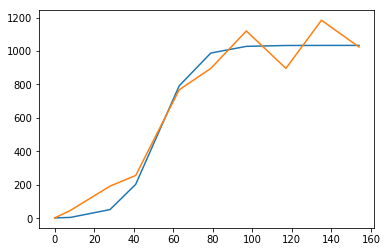

In [124]:
plt.plot(days, predict(solveLogisticGrowth,2,results["rate"],results["capacity"],days))
plt.plot(days,beetles)

In [5]:
# Part 2: MLE estimates and uncertainty  

import sympy as sp
sp.init_printing()
n_0, k, r, t, y = sp.symbols("n_0 k r t y")
logEQ=((((k * n_0) / (n_0 + (k-n_0) * sp.exp(-1 * r * t)))- y)**2)
H_inv=sp.hessian(logEQ,(r, k)).T.inv()
F=sp.Matrix(2,1,[sp.diff(logEQ,r),sp.diff(logEQ,k)])
N_R=-H_inv*F

array([0.69314718, 3.8501476 , 5.25749537, 5.54517744, 6.64378973,
       6.79794041, 7.02108396, 6.79794041, 7.07665382, 6.93147181])

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [60]:
# Read in data and initialize aic function

import pandas as pd
from sklearn.linear_model import LinearRegression
np.random.seed(711)

baseball = pd.read_table('/Users/matthewlenert/Documents/4F|Adv Stat Computing/Bios8366/data/baseball.dat', sep='\s+')

logsalary = baseball.salary.apply(np.log)
predictors = baseball.loc[:, 'average':]

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_


Best AIC: -417.5681464897959
Best Solution:-416.34747636830605


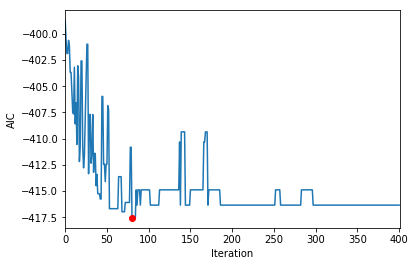

In [147]:
# Part 1

tau_start = 10
# cooling_schedule = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*240
cooling_schedule = [tau_start*0.99**i for i in range(400)]

def AIC_Annealing(data,outcome,cooling_schedule,neighborhoods=1):
    aic_values = []
    droppedColumns=[]
    predictors = data.copy()
    model = LinearRegression().fit(X=predictors, y=outcome)
    aic_best = aic(model, predictors, outcome)
    aic_best_predictors=predictors.columns.values
    aic_values.append(aic_best)
    
    
    for tau in cooling_schedule:
        # Make a random change either dropping or switching a predictor
        currentModel={}
        currentChange=[]
        switchedColumn=[]
        
        for _ in range(neighborhoods):
            switchOrDrop=(np.random.uniform()>0.5)
            currentChange.append(predictors.columns.values[np.random.randint(0,predictors.shape[1]-1)])
            
            if switchOrDrop:
                if len(droppedColumns)>0:
                    col=droppedColumns.pop(np.random.randint(0,len(droppedColumns)))
                    switchedColumn.append(col)
                    currentModel[col]=data[col]
                    
        currentModel=predictors.drop(currentChange,1)        
        model = LinearRegression().fit(X=currentModel, y=outcome)
        aic_step = aic(model, currentModel, outcome)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))
        
        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            droppedColumns.extend(currentChange)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                aic_best_predictors=currentModel.columns.values
                predictors = currentModel
                
        else:
            # Revert solution
            aic_values.append(aic_values[-1])
            if switchedColumn != None:
                droppedColumns.extend(switchedColumn)
    return {"Best_AIC":aic_best,"AIC_Progression":aic_values,"Best_Model":aic_best_predictors}

annealingResults=AIC_Annealing(predictors,logsalary,cooling_schedule,1)
print('Best AIC: {0}\nBest Solution:{1}'.format(annealingResults["Best_AIC"],annealingResults["AIC_Progression"][-1],))
plt.plot(annealingResults["AIC_Progression"])
plt.xlim(0, len(annealingResults["AIC_Progression"]))
plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.plot(np.where(annealingResults["AIC_Progression"]==annealingResults["Best_AIC"])[0][0], annealingResults["Best_AIC"], 'ro')



In [71]:
# Part 2
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def genetic_AIC(data,outcome,generations,pop_size,mutation_rate,randomDadSelection=True):
    aic_best = []
    best_solution = []
    aic_history = []
    ncols=data.shape[1]
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    
    for i in range(generations):
        # Get phenotype
        current_phe = [data[data.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=outcome), x, outcome) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        
        dads=[]
        if randomDadSelection:
            # 2nd parent is purely random
            dads = np.random.choice(range(pop_size), size=int(pop_size/2))
        else:
            # 2nd parent is chosen proportional to fitness
            dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
        
    return({"Best_AICs":aic_best,"Best_Columns":best_solution})

Best AIC: -420.94721143715475
Best Solution:-420.94721143715475


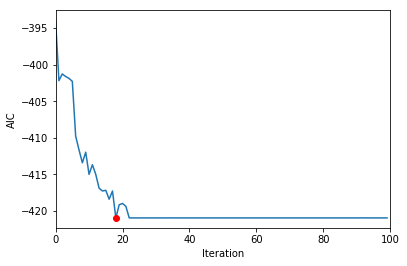

In [73]:
geneticResults=genetic_AIC(predictors,logsalary,100,20,0.02,False)
print('Best AIC: {0}\nBest Solution:{1}'.format(min(geneticResults["Best_AICs"]),geneticResults["Best_AICs"][-1],))
plt.plot(geneticResults["Best_AICs"])
plt.xlim(0, len(geneticResults["Best_AICs"]))
plt.xlabel('Iteration')
plt.ylabel('AIC')
plt.plot(np.where(geneticResults["Best_AICs"]==min(geneticResults["Best_AICs"]))[0][0], min(geneticResults["Best_AICs"]), 'ro')



## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there. I will award 5 bonus points to the best solution!

In [75]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('/Users/matthewlenert/Documents/4F|Adv Stat Computing/Bios8366/data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon).values

In [266]:
from math import atan2
from math import acos
from math import hypot
from shapely.geometry import Point, LineString
import sys


# Determine if point 3 is counter clockwise to line formed by point 1 and point 2
def counter_clockwise(p1, p2, p3):
    return (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])

def get_y(item):
    return(item[1])

# Find the convex hull for a set of points in R2
def graham_scan(locations):
    n=len(locations)
    if n>3:
        # Find lowest point on Y-axis
        loc_Array=sorted(locations,key=get_y)
        initPoint=loc_Array.pop(0)
        def polarAngle(b):
            return (atan2(b[1]-initPoint[1],b[0]-initPoint[0]))
        # Sort points by relative polar angle to initial point
        loc_Array=sorted(loc_Array,key=polarAngle,reverse=True)
        
        # Intialize solution
        convex_hull=[initPoint,loc_Array.pop(0),loc_Array.pop(0)]
        
        for point in loc_Array:
            # Check if counter clockwise 
            while counter_clockwise(convex_hull[-1],convex_hull[-2],point) <= 0:
                _=convex_hull.pop()
            convex_hull.append(point)
        return(convex_hull)
    else:
        return(locations)
    
def inList(location,list_of_locs):
    for loc in list_of_locs:
        if location[0]==loc[0]:
            if location[1]==loc[1]:
                return(True)

    return(False)
    
def dist(a,b):
    return(hypot(b[0] - a[0], b[1] - a[1]))

def calculate_total_dist(ordered_solution):
    distance=dist(ordered_solution[0],ordered_solution[-1])
    for index in range(len(ordered_solution)-1):
        distance+=dist(ordered_solution[index],ordered_solution[index+1])
    return(distance)

def point_angle(point,convex_1,convex_2):
    # Use Law of Cosines
    return(acos((dist(point,convex_1)**2+dist(point,convex_2)**2-dist(convex_1,convex_2)**2)/(2*dist(point,convex_1)*dist(point,convex_2))))


# Shrink the convex hull of a set of points in R2 until all points are included in the surface
def geometric_salesman_search(locations,initLocation):
    convex_hull=graham_scan(locations)
    
    # Sort solutions by polar angle relative to starting point
    def sort_solutions(b):
        return (atan2(b[1]-initLocation[1],b[0]-initLocation[0]))
    
    solution=sorted(convex_hull,key=sort_solutions)
    
    candidates=[]
    # Do not consider points already on convex hull
    for location in locations:
        if not inList(location,convex_hull):
            candidates.append(location)
    
    # Sort candidates list by shortest distance to the surface of the convex hull
    def sort_candidates(loc):
        minDist=sys.float_info.max
        for index in range(len(solution)):
            index2=index+1
            if index==(len(solution)-1):
                index2=0
            # Intialize Shapely objects
            l=LineString([solution[index],solution[index2]])
            p = Point(loc)
            # Use Shapely to find minimum distance between the point and the line
            cur_dist=p.distance(l)
            if cur_dist<minDist:
                minDist=cur_dist
        return(minDist)
    
    candidates=sorted(candidates,key=sort_candidates)
    
    for location in candidates:
        maxAngle=sys.float_info.max
        index_at_maxAngle=-1

        # Find angles to all possible sequential triplets of points
        for index in range(len(solution)):
            index2=index+1
            if index==(len(solution)-1):
                index2=0
                
            # Compare angle to Pi (180 degrees)
            angle=np.abs(point_angle(location,solution[index],solution[index2]) - np.pi)

            # Find the most obtuse angle
            if angle<maxAngle:
                maxAngle=angle
                index_at_maxAngle=index2

        # Insert into ordered solution at the optimal point
        solution.insert(index_at_maxAngle,location)

    return({"ordered_coordinates":solution,"total_distance":calculate_total_dist(solution)})

Total distance: 138.11046670095573 (LatLong)


Text(0,0.5,'Longitude')

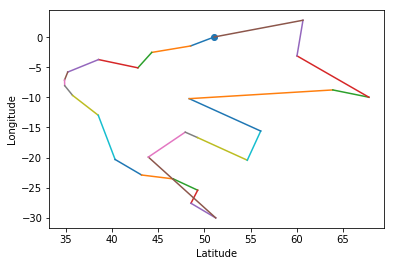

In [271]:
hull=geometric_salesman_search(cities,cities[0])
print("Total distance: "+str(hull['total_distance'])+" (LatLong)")

# Show each segment of the trip
for index in range(len(hull['ordered_coordinates'])-1):
    pointA=hull['ordered_coordinates'][index]
    pointB=hull['ordered_coordinates'][index+1]
    plt.plot([pointA[0],pointB[0]],[pointA[1],pointB[1]])
    
# Connect last location to first
plt.plot([hull['ordered_coordinates'][0][0],hull['ordered_coordinates'][-1][0]],[hull['ordered_coordinates'][0][1],hull['ordered_coordinates'][-1][1]])

# Add point to show starting location
plt.scatter(hull['ordered_coordinates'][0][0],hull['ordered_coordinates'][0][1])

plt.xlabel('Latitude')
plt.ylabel('Longitude')

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use pandas to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [274]:
import os
import numpy as np
import pandas as pd

# Set up file paths and parameters for file loading
path="/Users/matthewlenert/Documents/4F|Adv Stat Computing/Bios8366/data/ebola/"


# Record import column names in files and variables relevant to case/death count. 
# Case and death counts should include suspected and probable cases/deaths to avoid underestimating the scope of the outbreak

folders={"sl_data/":{"casesColVals":["new_suspected","new_probable","new_confirmed"]
                    ,"colNames":["date","variable","National"]
                    ,"deathColVals":["death_suspected","death_probable","death_confirmed"]}
         ,"guinea_data/":{"casesColVals":["New cases of suspects","New cases of probables","New cases of confirmed"]
                    ,"colNames":["Date","Description","Totals"]
                    ,"deathColVals":["New deaths registered","New deaths registered today (confirmed)","New deaths registered today (probables)","New deaths registered today (suspects)"]}
         ,"liberia_data/":{"casesColVals":["New Case/s (Suspected)","New Case/s (Probable)","New case/s (confirmed)"]
                    ,"colNames":["Date","Variable","National"]
                    ,"deathColVals":["Newly reported deaths"]}
        }



In [275]:
# Intialize output variable
countryDF=[]

# Loop over different country directories
for folder in folders:
    files = [f for f in os.listdir(path+folder)]
    
    columns=folders[folder]["colNames"]
    
    # Loop over files in country directory
    for f in files:
        df=pd.read_csv(path+folder+f,index_col=False)
        df=df.drop(columns[2],1)
        numericCols=[col for col in df.columns.values if col not in columns]
        
        # Convert death totals by province into integers
        death=df[df[columns[1]].isin(folders[folder]["deathColVals"])].drop(columns[1],1)
        death[numericCols]=death[numericCols].astype(np.float32)
        
        # Sum death totals by province to form national total
        death=death.groupby(columns[0]).sum()
        death["Deaths"]=death.sum(axis=1)
        
        # Add Country label
        death["Country"]=folder.split("_")[0]
        
        # Convert case totals by province into integers
        cases=df[df[columns[1]].isin(folders[folder]["casesColVals"])].drop(columns[1],1)
        cases[numericCols]=cases[numericCols].astype(np.float32)
        
        # Sum case total by province to form national total
        cases=cases.groupby(columns[0]).sum()
        death["Cases"]=cases.sum(axis=1)
        
        # Append to list to concatenate
        countryDF.append(death[["Country","Cases","Deaths"]])
         
# Concatenate rows into single dataframe and convert index to dateTime        
countryDF=pd.concat(countryDF,axis=0)
countryDF.index=pd.to_datetime(countryDF.index)    

# Add Country column to index and re-sort data to make the index functional
countryDF=countryDF.set_index(['Country'], append=True)
countryDF.sort_index(ascending=True, inplace=True)

In [276]:
# NANs are left to show where data is truly missing. NANs should be addressed through an imputation strategy later in the pipeline. 
countryDF

,,Cases,Deaths
,Country,,
2014-06-16,liberia,4.0,1.0
2014-06-17,liberia,2.0,0.0
2014-06-22,liberia,10.0,4.0
2014-06-24,liberia,6.0,4.0
2014-06-25,liberia,7.0,3.0
2014-06-28,liberia,9.0,1.0
2014-06-29,liberia,2.0,0.0
2014-07-01,liberia,4.0,5.0
2014-07-02,liberia,4.0,5.0
